# En el siguiente notebook vamos a trabajar solo con la simulación, considerando el equivalente  a las 350  estrellas de los datos reales. Haremos un subsampleo considerando la mascara del plano galáctico, y diferentes 'seeds'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord, CartesianRepresentation
from astropy.wcs import WCS
import gala.coordinates as gc
import healpy as hp
from pylab import cm
import matplotlib as mpl
from matplotlib.patches import Circle, PathPatch, Ellipse
from healpy.newvisufunc import projview, newprojplot
from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import cartesian_to_spherical
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.legend_handler import HandlerTuple
import datosCM
import pymaster as nmt

from matplotlib.patches import Rectangle

In [2]:
from astropy.coordinates import SkyCoord

def cat_to_hpx(lon, lat, nside, radec=False):   #radec=False: si vamos de cartesianas a esfericas galacticas
    """
    Convierte un catálogo a un mapa HEALPix de densidad de número, es decir,
    el número de estrellas por grado cuadrado de cielo.

    Parámetros
    ----------
    lon, lat : (arreglo, arreglo)
        Coordenadas de las fuentes en grados.
        Si radec=True, asume que la entrada está en el sistema ICRS,
        De lo contrario, asume que la entrada está en latitud y longitud galáctica.

    nside : int
        Número HEALPix nside del mapa de destino, define el número de píxeles.

    radec : bool
        Cambio entre Ra/Dec y l/b (galáctico) como sistema de coordenadas de entrada.

    Return
    ------
    hpx_map : arreglo
        Mapa HEALPix de los recuentos de número del catálogo en coordenadas galácticas
    """
    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # OJO ACA  

    theta = np.radians(90. - b)                 # latitud en radianes
    phi = np.radians(l)               # longitud en radianes        
    indices = hp.ang2pix(nside, theta, phi, lonlat=False)  


    indx, counts = np.unique(indices, return_counts=True)

    # llenar el mapa de cielo completo
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[indx] = counts

    return hpx_map


In [3]:
fwhm2sigma = lambda fwhm: fwhm / np.sqrt(8*np.log(2))


# Parámetros a usar 

In [4]:
nside=128
lmax=3*nside-1
#lmax=47
espesor=5 #kpc
radio=70 #kpc

radio_min=radio-espesor/2
radio_max=radio+espesor/2

# Leyendo los datos de la simulación 

In [5]:
#lectura de datos

simu = pd.read_csv('/home/marz/Dropbox/PlanAB/gkrr/Wake/notebooks wake simu/rand_mwlmc5b0_110.txt', sep=' ',
                  names=['x','y','z','vx', 'vy', 'vz'])

#mc = pd.read_csv('/content/drive/MyDrive/rand_mwb1_110.txt', sep=' ',
                  #names=['x','y','z','vx', 'vy', 'vz'])
#pd.DataFrame(mc)

# con x,y,z en kpc y vx, vy, vz en km/s

simu

,x,y,z,vx,vy,vz
0,-9.073973,134.529449,52.583729,-162.274078,-29.927361,96.407394
1,-28.404976,53.197102,-136.105240,-43.992241,-72.750572,230.643051
2,5.671879,-50.859417,-20.001068,-39.119331,72.849449,222.935043
3,-34.947304,-43.726669,-15.888982,-2.000596,-104.936783,241.940506
4,-48.037086,22.731808,-69.944145,164.281570,-77.371971,-42.808468
...,...,...,...,...,...,...
999995,-52.940460,1.057030,-0.767179,-26.956795,113.120132,-29.164295
999996,3.171290,35.912395,-35.208454,157.058807,103.576843,-51.752743
999997,11.692700,5.368427,64.118584,-206.644135,10.167513,-39.430645
999998,-79.273514,155.210205,-20.541859,14.234056,127.901489,-28.539112


## Cálculo de las coordenadas $r,\theta, \phi$ con ```astropy```

In [6]:
from astropy.coordinates import cartesian_to_spherical

x = simu['x'].values #* u.Mpc
y = simu['y'].values #* u.Mpc
z = simu['z'].values #* u.Mpc

#
spherical_coords = cartesian_to_spherical(x, y, z)

#
r = spherical_coords[0]#.to(u.Mpc, equivalencies=u.dimensionless_angles()).value
theta = spherical_coords[1].to(u.rad).value
phi = spherical_coords[2].to(u.rad).value
phi2 = spherical_coords[2].to(u.degree).value

# Añadir los resultados de nuevo al DataFrame
simu['R'] = r                #kpc
simu['theta'] = theta        #rad
simu['phi'] = phi            #rad
simu['phi2'] = phi2         # en grados
simu['cotheta'] = np.pi/2 - theta          #rad

simu

,x,y,z,vx,vy,vz,R,theta,phi,phi2,cotheta
0,-9.073973,134.529449,52.583729,-162.274078,-29.927361,96.407394,144.725804,0.371843,1.638144,93.858739,1.198953
1,-28.404976,53.197102,-136.105240,-43.992241,-72.750572,230.643051,148.867090,-1.153711,2.061239,118.100309,2.724507
2,5.671879,-50.859417,-20.001068,-39.119331,72.849449,222.935043,54.944456,-0.372584,4.823451,276.363373,1.943380
3,-34.947304,-43.726669,-15.888982,-2.000596,-104.936783,241.940506,58.187588,-0.276577,4.038123,231.367392,1.847374
4,-48.037086,22.731808,-69.944145,164.281570,-77.371971,-42.808468,87.843498,-0.921048,2.699603,154.675846,2.491844
...,...,...,...,...,...,...,...,...,...,...,...
999995,-52.940460,1.057030,-0.767179,-26.956795,113.120132,-29.164295,52.956569,-0.014487,3.121629,178.856162,1.585284
999996,3.171290,35.912395,-35.208454,157.058807,103.576843,-51.752743,50.392385,-0.773559,1.482719,84.953513,2.344356
999997,11.692700,5.368427,64.118584,-206.644135,10.167513,-39.430645,65.396728,1.372764,0.430417,24.661104,0.198033
999998,-79.273514,155.210205,-20.541859,14.234056,127.901489,-28.539112,175.489218,-0.117324,2.043006,117.055644,1.688120


# SOlo sobredensidad

## Densidad con cat_to_pix y

### Contraste de densidad 


$$\Delta = \frac{\rho - \bar{\rho}}{\bar{\rho}}$$

# Primero sobre toda la simuladión con máscara pero sin condición de distancia

In [233]:
# Convertir coordenadas esféricas a galácticas

l_deg = np.degrees(phi)
b_deg = np.degrees(theta)

# OJO AQUI. cat_to_hpx espera el mapa en grados, no en radianes
mapa_simu = cat_to_hpx(l_deg, b_deg, nside=nside, radec=False)
mapa_simu_mean = mapa_simu.mean()
#sobredensidad (no suavizado)
sobre_simu = (mapa_simu - mapa_simu_mean) / mapa_simu_mean




In [234]:
l_sim = coord.Angle(simu['phi'].values*180/np.pi*u.degree)
l_sim = l_sim.wrap_at(180*u.degree)
b_sim = coord.Angle(simu['theta'].values*180/np.pi*u.degree)

simulacion= SkyCoord(l=l_sim, b=b_sim, frame='galactic')
ipix_simulacion = hp.ang2pix(nside, np.pi/2- simulacion.galactic.b.radian, simulacion.galactic.l.radian)

/tmp/ipykernel_82364/3088702759.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


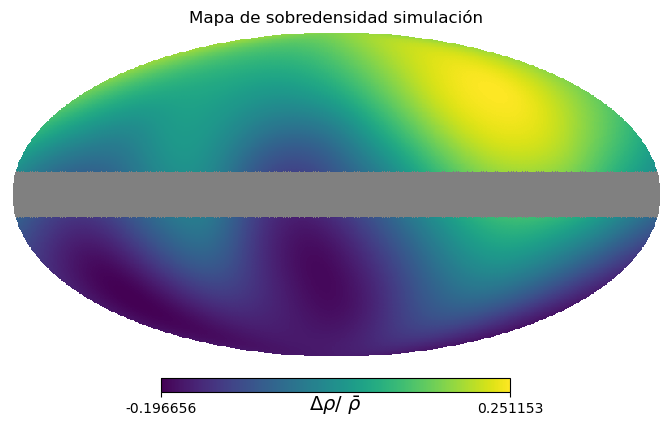

In [235]:
#sobredensidad (no suavizado)
l = simulacion.galactic.l.degree
b = simulacion.galactic.b.degree
mapa_simulacion = cat_to_hpx(l, b, nside=nside, radec=False)
mapa_simulacion_mean = mapa_simulacion.mean()
mapa_simulacion = (mapa_simulacion - mapa_simulacion_mean) / mapa_simulacion_mean

# Suavizar el mapa SOLO para visualización
mapa_simulacion_smooth= hp.sphtfunc.smoothing(mapa_simulacion, sigma=np.radians(fwhm2sigma(30)))

# Crear máscara del plano galáctico |b| < 10°
xg, yg = np.meshgrid(
    np.pi/2 - np.linspace(np.radians(-10), np.radians(10), 10000),
    np.linspace(0, 2*np.pi, 10000)
)
mask = hp.ang2pix(nside, xg, yg)

# Crear copia enmascarada del mapa suavizado solo
mapa_simulacion_smooth_masked = mapa_simulacion_smooth.copy()
mapa_simulacion_smooth_masked[mask] = hp.UNSEEN

# Crear copia enmascarada del mapa NO suavizado (para calculos  de alm y cls)
mapa_simulacion_masked = mapa_simulacion.copy()
mapa_simulacion_masked[mask] = hp.UNSEEN
# 
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot()

mmin, mmax = np.min(mapa_simulacion_smooth_masked[np.isfinite(mapa_simulacion_smooth_masked)]), np.max(mapa_simulacion_smooth_masked[np.isfinite(mapa_simulacion_smooth_masked)])

hp.mollview(mapa_simulacion_smooth_masked, title='Mapa de sobredensidad simulación', 
            unit=r"$\Delta \rho /\ \bar{\rho}$",  cbar=True, flip='astro', hold=True) 

plt.tight_layout()
plt.savefig('mapa_simulacion_smooth_masked_'+str(radio)+'.pdf')
plt.show()


# Para los Cls

In [236]:
cl_simu=hp.anafast(mapa_simulacion_masked, alm=True,lmax=lmax, pol=False)

In [241]:
len(cl_simu[0])

384

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_82364/3055666215.py:8: SyntaxWarning: invalid escape sequence '\e'
  label="$C_{\ell}$ Simu", marker="o", linestyle="--", color='orange', alpha=0.7)
/tmp/ipykernel_82364/3055666215.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel('$\ell$')
/tmp/ipykernel_82364/3055666215.py:11: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel('$C_{\ell}$')
/

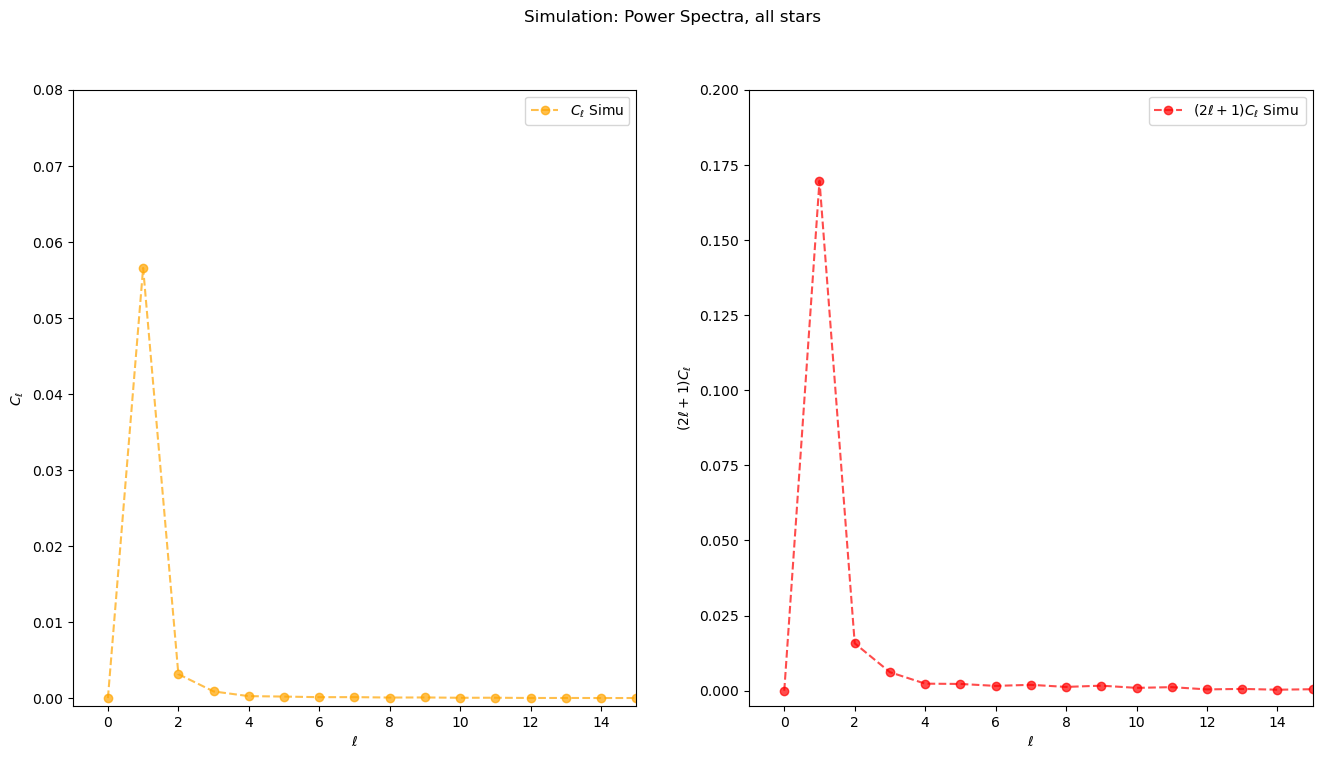

In [240]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Simulation: Power Spectra, all stars')

ells = np.arange(lmax + 1)


ax[0].plot(ells, cl_simu[0][:lmax + 1], 
         label="$C_{\ell}$ Simu", marker="o", linestyle="--", color='orange', alpha=0.7)
ax[0].set_xlabel('$\ell$')
ax[0].set_xlim(-1,15)
ax[0].set_ylabel('$C_{\ell}$')
ax[0].set_ylim(-0.001, 0.08)
ax[0].legend()

ax[1].plot(ells, (2*ells +1)*cl_simu[0][:lmax + 1], 
         label="$(2 \ell +1) C_{\ell}$ Simu ", marker="o", linestyle="--", color='red', alpha=0.7)
ax[1].set_xlabel('$\ell$')
ax[1].set_xlim(-1,15)
ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$')
ax[1].set_ylim(-0.005, 0.20)
ax[1].legend()

#plt.savefig('cl_sobre_simu_'+str(radio)+'.pdf') 

plt.show()



### Condición para un anillo de 70 kpc $\pm$ 5 kpc 

In [7]:
simu['vr'] = np.sin(simu['cotheta']) * np.cos(simu['phi'])* simu['vx'] + np.sin(simu['cotheta']) * np.sin(simu['phi']) * simu['vy'] + np.cos(simu['cotheta']) * simu['vz']
simu['vtheta'] = np.cos(simu['cotheta'])* np.cos(simu['phi']) * simu['vx'] + np.sin(simu['phi']) * np.cos(simu['cotheta']) * simu['vy'] - np.sin(simu['cotheta']) * simu['vz']
simu['vphi'] =  ( np.sin(simu['phi'])) * simu['vx'] -  np.cos(simu['phi']) * simu['vy']

simu_condicion70=simu[(simu['R']<radio_max) & (simu['R']>radio_min)]
simu_condicion70.reset_index(drop=True, inplace=True)
print(len(simu_condicion70))

simu_condicion70

40261


,x,y,z,vx,vy,vz,R,theta,phi,phi2,cotheta,vr,vtheta,vphi
0,-53.061398,41.455952,22.344593,86.953850,13.938704,-154.251755,70.946379,0.320404,2.478369,142.000104,1.250392,-105.470404,127.523727,64.517875
1,0.624012,50.123386,-51.375473,16.287613,178.196594,-109.710022,71.778705,-0.797695,1.558347,89.286732,2.368491,203.101807,-51.062188,14.068061
2,-54.970650,44.175541,-5.324710,85.223404,66.308495,11.412510,70.722014,-0.075362,2.464648,141.213928,1.646158,-25.682817,-9.505814,105.071989
3,14.865033,54.219166,-41.813835,-170.884308,118.176590,194.248260,70.064855,-0.639492,1.303206,74.668202,2.210288,-60.729869,-196.916217,-196.049550
4,22.350819,61.281734,-26.018353,14.321036,2.820848,4.897541,70.227948,-0.379530,1.221066,69.961957,1.950327,5.204871,-7.348815,12.487570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40256,41.628483,-11.116068,-54.504440,196.042603,103.060272,79.880615,69.478281,-0.901860,6.022243,345.049131,2.472656,38.306689,-177.265441,-150.148577
40257,3.573742,-28.529005,-61.892181,-31.530685,-15.743123,-209.615891,68.244545,-1.135909,4.837007,277.140077,2.706706,195.034459,77.700169,33.242973
40258,15.123265,-64.108955,-22.831352,51.960236,185.951706,-43.565121,69.713284,-0.333660,4.944053,283.273377,1.904457,-145.463103,96.528358,-93.266203
40259,16.201511,-35.835152,60.443825,-21.060043,-17.799568,132.427338,72.111740,0.993968,5.136998,294.328309,0.576828,115.113857,-65.899136,26.522700


In [208]:
# Convertir coordenadas esféricas a galácticas

l_deg = np.degrees(phi)
b_deg = np.degrees(theta)

# OJO AQUI. cat_to_hpx espera el mapa en grados, no en radianes
mapa_simu = cat_to_hpx(l_deg, b_deg, nside=nside, radec=False)
mapa_simu_mean = mapa_simu.mean()
#sobredensidad (no suavizado)
sobre70_simu = (mapa_simu - mapa_simu_mean) / mapa_simu_mean




In [209]:
l_sim = coord.Angle(simu_condicion70['phi'].values*180/np.pi*u.degree)
l_sim = l_sim.wrap_at(180*u.degree)
b_sim = coord.Angle(simu_condicion70['theta'].values*180/np.pi*u.degree)

simulacion= SkyCoord(l=l_sim, b=b_sim, frame='galactic')
ipix_simulacion = hp.ang2pix(nside, np.pi/2- simulacion.galactic.b.radian, simulacion.galactic.l.radian)

/tmp/ipykernel_82364/3088702759.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


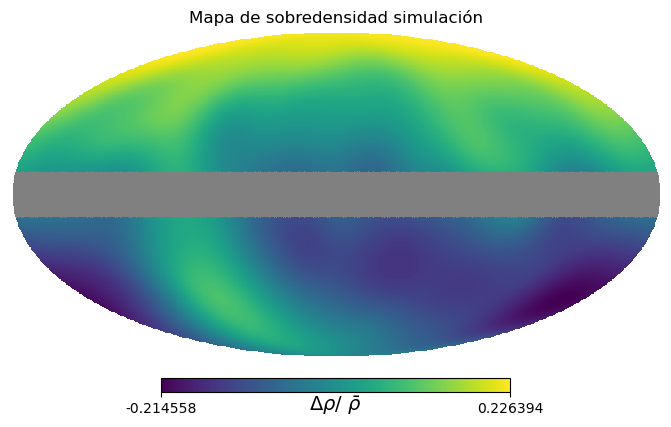

In [210]:
#sobredensidad (no suavizado)
l = simulacion.galactic.l.degree
b = simulacion.galactic.b.degree
mapa_simulacion = cat_to_hpx(l, b, nside=nside, radec=False)
mapa_simulacion_mean = mapa_simulacion.mean()
mapa_simulacion = (mapa_simulacion - mapa_simulacion_mean) / mapa_simulacion_mean

# Suavizar el mapa SOLO para visualización
mapa_simulacion_smooth= hp.sphtfunc.smoothing(mapa_simulacion, sigma=np.radians(fwhm2sigma(30)))

# Crear máscara del plano galáctico |b| < 10°
xg, yg = np.meshgrid(
    np.pi/2 - np.linspace(np.radians(-10), np.radians(10), 10000),
    np.linspace(0, 2*np.pi, 10000)
)
mask = hp.ang2pix(nside, xg, yg)

# Crear copia enmascarada del mapa suavizado solo
mapa_simulacion_smooth_masked = mapa_simulacion_smooth.copy()
mapa_simulacion_smooth_masked[mask] = hp.UNSEEN

# Crear copia enmascarada del mapa NO suavizado (para calculos  de alm y cls)
mapa_simulacion_masked = mapa_simulacion.copy()
mapa_simulacion_masked[mask] = hp.UNSEEN
# 
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot()

mmin, mmax = np.min(mapa_simulacion_smooth_masked[np.isfinite(mapa_simulacion_smooth_masked)]), np.max(mapa_simulacion_smooth_masked[np.isfinite(mapa_simulacion_smooth_masked)])

hp.mollview(mapa_simulacion_smooth_masked, title='Mapa de sobredensidad simulación', 
            unit=r"$\Delta \rho /\ \bar{\rho}$",  cbar=True, flip='astro', hold=True) 

plt.tight_layout()
plt.savefig('mapa_simulacion_smooth_masked_'+str(radio)+'.pdf')
plt.show()


In [223]:
cl_simu70 = hp.anafast(mapa_simulacion_masked, lmax=lmax, alm=True, pol=False)
print(len(cl_simu70[0]))

384


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_82364/2849894204.py:8: SyntaxWarning: invalid escape sequence '\e'
  label="$C_{\ell}$ Simu", marker="o", linestyle="--", color='orange', alpha=0.7)
/tmp/ipykernel_82364/2849894204.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel('$\ell$')
/tmp/ipykernel_82364/2849894204.py:11: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel('$C_{\ell}$')
/

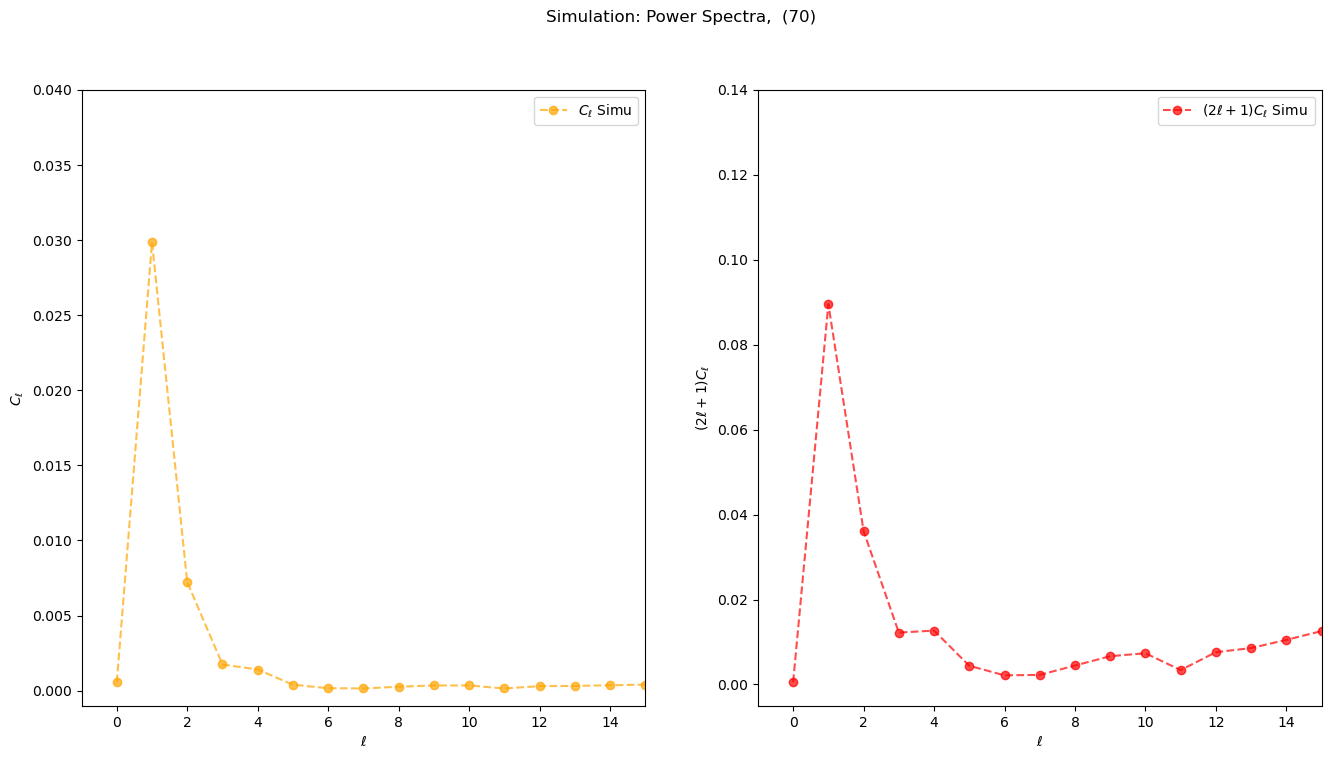

In [221]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Simulation: Power Spectra,  ('+str(radio)+')')

ells = np.arange(lmax + 1)


ax[0].plot(ells, cl_simu70[0][:lmax + 1], 
         label="$C_{\ell}$ Simu", marker="o", linestyle="--", color='orange', alpha=0.7)
ax[0].set_xlabel('$\ell$')
ax[0].set_xlim(-1,15)
ax[0].set_ylabel('$C_{\ell}$')
ax[0].set_ylim(-0.001, 0.04)
ax[0].legend()

ax[1].plot(ells, (2*ells +1)*cl_simu70[0][:lmax + 1], 
         label="$(2 \ell +1) C_{\ell}$ Simu ", marker="o", linestyle="--", color='red', alpha=0.7)
ax[1].set_xlabel('$\ell$')
ax[1].set_xlim(-1,15)
ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$')
ax[1].set_ylim(-0.005, 0.14)
ax[1].legend()

#plt.savefig('cl_sobre_simu_'+str(radio)+'.pdf') 

plt.show()



# Para el muestreo aleatorio

In [22]:
simu_sample = simu_condicion70.sample(n=2150,random_state=40)
simu_sample.reset_index(drop=True, inplace=True)
simu_sample

,x,y,z,vx,vy,vz,R,theta,phi,phi2,cotheta,vr,vtheta,vphi
0,31.188370,-33.515476,-53.502384,59.327408,157.583755,212.287766,70.416665,-0.863001,5.461837,312.940216,2.433797,-210.022317,-81.077560,-150.783064
1,55.420830,-41.344215,11.146303,56.649117,89.528259,178.542038,70.036081,0.159831,5.642246,323.276878,1.410966,20.391619,-177.559823,-105.633243
2,57.626495,20.984303,-32.215057,9.949466,77.878769,15.838718,69.274554,-0.483674,0.349219,20.008756,2.054470,24.501627,-30.761379,-69.773687
3,63.642624,13.111729,31.057419,27.249073,184.579147,40.980408,72.019888,0.445860,0.203178,11.641265,1.124936,75.355572,-9.403847,-175.283978
4,2.529681,-59.558197,38.411724,-58.109310,-7.463697,-76.883606,70.915715,0.572403,4.754838,272.432125,0.998394,-37.448759,67.331939,58.373693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,33.284775,43.360065,44.257515,226.061142,118.130020,60.688042,70.332774,0.680599,0.916103,52.488835,0.890197,217.998247,98.416977,107.388281
2146,68.080307,6.507912,4.767335,-217.908585,-37.613491,-134.903244,68.556609,0.069595,0.095302,5.460409,1.501201,-229.346198,119.243474,16.707082
2147,-22.272858,54.679493,-40.616035,-134.072052,-166.288559,160.547974,71.663027,-0.602573,1.957610,112.162775,2.173369,-176.202835,-73.654557,-186.896814
2148,14.369035,-39.955849,55.514019,15.427367,-9.451784,127.349197,69.890953,0.917846,5.057611,289.779742,0.652950,109.728024,-66.157443,-11.318627


In [23]:
l_sim = coord.Angle(simu_sample['phi'].values*180/np.pi*u.degree)
l_sim = l_sim.wrap_at(180*u.degree)
b_sim = coord.Angle(simu_sample['theta'].values*180/np.pi*u.degree)

simulacion= SkyCoord(l=l_sim, b=b_sim, frame='galactic')
ipix_simulacion = hp.ang2pix(nside, np.pi/2- simulacion.galactic.b.radian, simulacion.galactic.l.radian)

## Usando la mascara. Sobredensidad:

/tmp/ipykernel_82364/3088702759.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


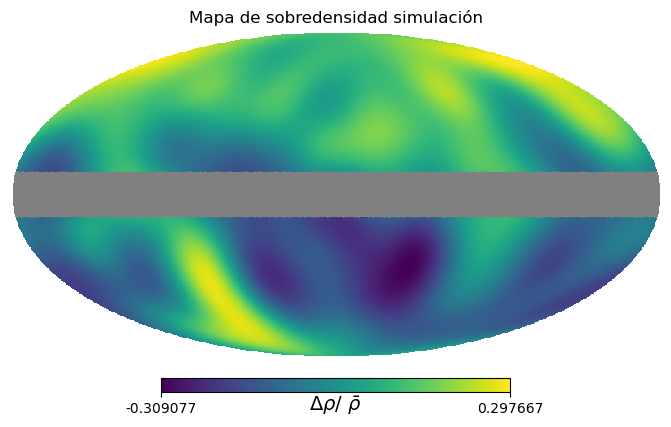

In [24]:
#sobredensidad (no suavizado)
l = simulacion.galactic.l.degree
b = simulacion.galactic.b.degree
mapa_simulacion = cat_to_hpx(l, b, nside=nside, radec=False)
mapa_simulacion_mean = mapa_simulacion.mean()
mapa_simulacion = (mapa_simulacion - mapa_simulacion_mean) / mapa_simulacion_mean

# Suavizar el mapa SOLO para visualización
mapa_simulacion_smooth= hp.sphtfunc.smoothing(mapa_simulacion, sigma=np.radians(fwhm2sigma(30)))

# Crear máscara del plano galáctico |b| < 10°
xg, yg = np.meshgrid(
    np.pi/2 - np.linspace(np.radians(-10), np.radians(10), 10000),
    np.linspace(0, 2*np.pi, 10000)
)
mask = hp.ang2pix(nside, xg, yg)

# Crear copia enmascarada del mapa suavizado solo
mapa_simulacion_smooth_masked = mapa_simulacion_smooth.copy()
mapa_simulacion_smooth_masked[mask] = hp.UNSEEN

# Crear copia enmascarada del mapa NO suavizado (para calculos  de alm y cls)
mapa_simulacion_masked = mapa_simulacion.copy()
mapa_simulacion_masked[mask] = hp.UNSEEN
# 
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot()

mmin, mmax = np.min(mapa_simulacion_smooth_masked[np.isfinite(mapa_simulacion_smooth_masked)]), np.max(mapa_simulacion_smooth_masked[np.isfinite(mapa_simulacion_smooth_masked)])

hp.mollview(mapa_simulacion_smooth_masked, title='Mapa de sobredensidad simulación', 
            unit=r"$\Delta \rho /\ \bar{\rho}$",  cbar=True, flip='astro', hold=True) 

plt.tight_layout()
plt.savefig('mapa_simulacion_smooth_masked_'+str(radio)+'.pdf')
plt.show()


In [26]:
mask_fuera_plano = np.abs(b) >= 10
print(f"Estrellas fuera del plano: {np.sum(mask_fuera_plano)} / {len(simulacion)}")
print("estrellas disponibles: ", len(simulacion) - np.sum(mask_fuera_plano))

Estrellas fuera del plano: 1798 / 2150
estrellas disponibles:  352


## Para un solo submuestreo

In [36]:
cl_simu70_sub = hp.anafast(mapa_simulacion_masked, alm=True, lmax=lmax)

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_82364/1839127744.py:8: SyntaxWarning: invalid escape sequence '\e'
  label="$C_{\ell}$ Simu", marker="o", linestyle="--", color='orange', alpha=0.7)
/tmp/ipykernel_82364/1839127744.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel('$\ell$')
/tmp/ipykernel_82364/1839127744.py:11: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel('$C_{\ell}$')
/

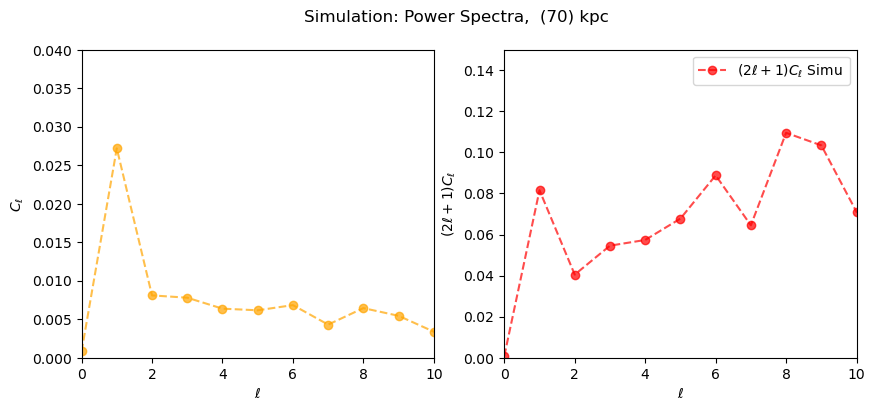

In [62]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.suptitle('Simulation: Power Spectra,  ('+str(radio)+') kpc')

ells = np.arange(lmax + 1)


ax[0].plot(ells, cl_simu70_sub[0][:lmax + 1], 
         label="$C_{\ell}$ Simu", marker="o", linestyle="--", color='orange', alpha=0.7)
ax[0].set_xlabel('$\ell$')
ax[0].set_xlim(0, 10)
ax[0].set_ylabel('$C_{\ell}$')
ax[0].set_ylim(0, 0.04)

ax[1].plot(ells, (2*ells +1)*cl_simu70_sub[0][:lmax + 1], 
         label="$(2 \ell +1) C_{\ell}$ Simu ", marker="o", linestyle="--", color='red', alpha=0.7)
ax[1].set_xlabel('$\ell$')
ax[1].set_xlim(0, 10)
ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$')
ax[1].set_ylim(0, 0.15)
ax[1].legend()



plt.show()



In [ ]:
N = 100  # numero de submuestreos
n_muestreo = 2150

cls_all = []

# mascara del plano 
xg, yg = np.meshgrid(
    np.pi/2 - np.linspace(np.radians(-10), np.radians(10), 10000),
    np.linspace(0, 2*np.pi, 10000)
)
mask_pix = hp.ang2pix(nside, xg, yg)

for seed in range(N):
    # para el submuestreo aleatorio
    simu_sample = simu_condicion70.sample(n=n_muestreo, random_state=seed).reset_index(drop=True)

    # de radianes a grados l y b 
    l_sim = coord.Angle(simu_sample['phi'].values * 180/np.pi * u.deg).wrap_at(180 * u.deg)
    b_sim = coord.Angle(simu_sample['theta'].values * 180/np.pi * u.deg)
    simulacion = SkyCoord(l=l_sim, b=b_sim, frame='galactic')
    l = simulacion.galactic.l.degree
    b = simulacion.galactic.b.degree

    # mapa de sobredensidad
    mapa = cat_to_hpx(l, b, nside=nside, radec=False)
    mapa_mean = mapa.mean()
    mapa = (mapa - mapa_mean) / mapa_mean

    # usando la mascarA
    mapa_masked = mapa.copy()
    mapa_masked[mask_pix] = hp.UNSEEN

    # Calcular Cl y alm
    cl, alm = hp.anafast(mapa_masked, alm=True, lmax=lmax)
    cls_all.append(cl)

# Convertir a array y calcular estadística
cls_all = np.array(cls_all)
ell = np.arange(cls_all.shape[1])
cl_mean = np.mean(cls_all, axis=0)
cl_std = np.std(cls_all, axis=0)




<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_82364/492233623.py:14: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel('$\ell$')
/tmp/ipykernel_82364/492233623.py:16: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel('$C_{\ell}$')
/tmp/ipykernel_82364/492233623.py:27: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_xlabel('$\ell$')
/tmp/ipykernel_82364/492233623.py:29: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$')


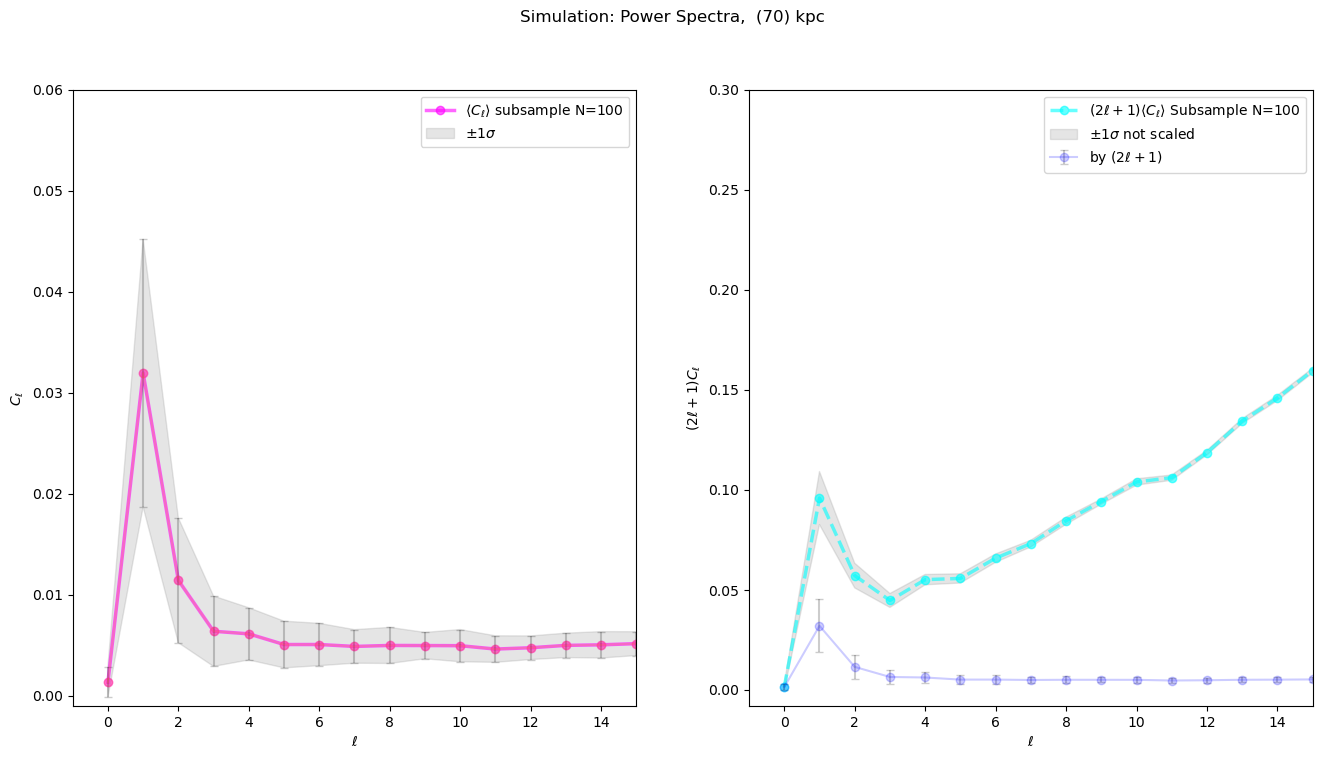

In [207]:

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Simulation: Power Spectra,  ('+str(radio)+') kpc')

ells = np.arange(lmax + 1)

ax[0].plot(ells, cl_mean, marker="o",  color='magenta', alpha=0.6,lw=2.5,label=r"$\langle C_{\ell} \rangle $ subsample N=100")
ax[0].fill_between(ell, cl_mean - cl_std, cl_mean + cl_std, color='grey', alpha=0.2, label=r"$\pm 1\sigma$")
#ax[0].bar(ell, cl_mean, yerr=cl_std, align='center', alpha=0.1, ecolor='black', capsize=1)
# Solo los puntos con barra de error
ax[0].errorbar(ell, cl_mean, yerr=cl_std, fmt='o-', color='orange',alpha=0.2,
             ecolor='black', capsize=3, label=r"")


ax[0].set_xlabel('$\ell$')
ax[0].set_xlim(-1, 15)
ax[0].set_ylabel('$C_{\ell}$')
ax[0].set_ylim(-0.001, 0.06)
ax[0].legend()


cl_mean_weighted = (2 * ell + 1) * cl_mean
ax[1].plot(ells, (2*ells +1)*cl_mean,
          marker="o", linestyle="--", color='cyan', alpha=0.6, lw=2.5,label=r"$ (2 \ell +1) \langle C_{\ell} \rangle$ Subsample N=100")
ax[1].fill_between(ell, (2*ells +1)*cl_mean - cl_std, (2*ells +1)*cl_mean + cl_std, color='grey', alpha=0.2, label=r"$\pm 1 \sigma$ not scaled ")
ax[1].errorbar(ell, cl_mean , yerr=cl_std , fmt='o-', color='blue', alpha=0.2,
             ecolor='black', capsize=3, label=r"by $(2\ell +1)$")
ax[1].set_xlabel('$\ell$')
ax[1].set_xlim(-1, 15)
ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$')
ax[1].set_ylim(-0.008, 0.3)
ax[1].legend()



plt.show()



<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_82364/4032372093.py:13: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel('$\ell$')
/tmp/ipykernel_82364/4032372093.py:15: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel('$C_{\ell}$')
/tmp/ipykernel_82364/4032372093.py:29: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_xlabel('$\ell$')
/tmp/ipykernel_82364/4032372093.py:30: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$')


(-0.008, 0.3)

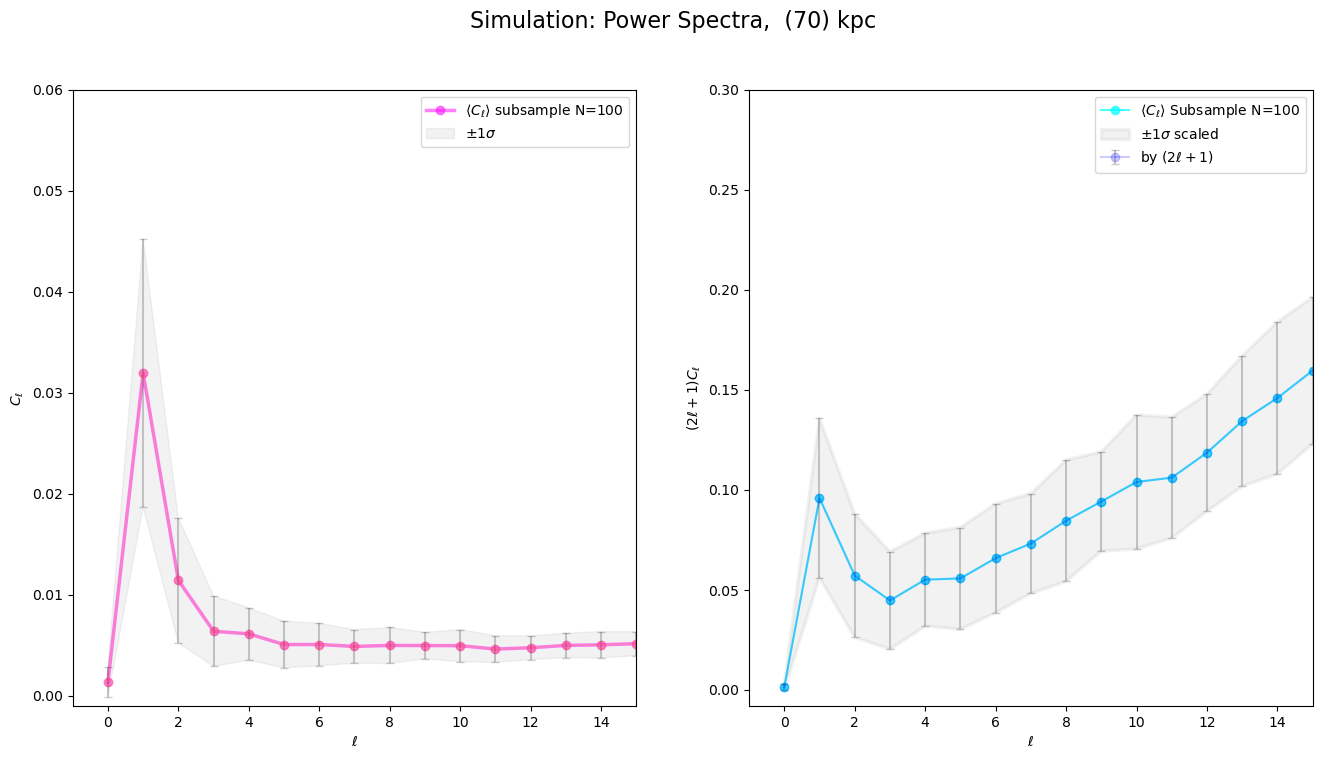

In [200]:

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Simulation: Power Spectra,  ('+str(radio)+') kpc', fontsize=16)

ells = np.arange(lmax + 1)


ax[0].plot(ells, cl_mean, marker="o",  color='magenta', alpha=0.5,lw=2.5,label=r"$\langle C_{\ell} \rangle $ subsample N=100")
ax[0].fill_between(ell, cl_mean - cl_std, cl_mean + cl_std, color='grey', alpha=0.1, label=r"$\pm 1\sigma$")
#ax[0].bar(ell, cl_mean, yerr=cl_std, align='center', alpha=0.1, ecolor='black', capsize=1)
# Solo los puntos con barra de error
ax[0].errorbar(ell, cl_mean, yerr=cl_std, fmt='o-', color='orange',alpha=0.2,
             ecolor='black', capsize=3, label=r"")
ax[0].set_xlabel('$\ell$')
ax[0].set_xlim(-1, 15)
ax[0].set_ylabel('$C_{\ell}$')
ax[0].set_ylim(-0.001, 0.06)
ax[0].legend()


cl_mean_weighted = (2 * ell + 1) * cl_mean
cl_std_weighted = (2 * ell + 1) * cl_std

ax[1].plot(ell, cl_mean_weighted,color='cyan',alpha=0.7,marker='o',label=r"$\langle C_{\ell} \rangle $ Subsample N=100")
ax[1].fill_between(ell, cl_mean_weighted - cl_std_weighted,
                        cl_mean_weighted + cl_std_weighted,
                        color='grey', alpha=0.1, lw=2.5, label=r"$\pm 1\sigma$ scaled ")
ax[1].errorbar(ell, cl_mean_weighted , yerr=cl_std_weighted , fmt='o-', color='blue', alpha=0.2,
             ecolor='black', capsize=3, label=r"by $(2\ell +1)$")
ax[1].set_xlabel('$\ell$')
ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$')
ax[1].legend()
ax[1].set_xlim(-1, 15)
ax[1].set_ylim(-0.008, 0.3)


In [232]:


# Cálculo del chi-cuadrado
chi2 = np.sum((cl_simu70[0] - cl_mean[0])**2 / cl_std[0]**2)

# Grados de libertad (número de multipolos - 1)
dof = len(cl_mean) - 1

# Chi-cuadrado reducido
chi2_red = chi2 / dof

print(f"Chi-cuadrado total: {chi2:.3f}")
print(f"Chi-cuadrado reducido: {chi2_red:.3f}")


Chi-cuadrado total: 561.655
Chi-cuadrado reducido: 1.466


In [228]:
print(len(cl_simu70[0]), len(cl_mean), len(cl_std))

384 384 384


# Guardar todos los Cls en un df:

In [244]:
# Escalado (2l + 1)
ell = ells  # array de multipolos

cl_mean_scaled       = (2 * ell + 1) * cl_mean
cl_simu70_scaled     = (2 * ell + 1) * cl_simu70[0]
cl_simu_scaled       = (2 * ell + 1) * cl_simu[0]
cl_std_scaled = (2 * ell + 1) * cl_std

# Construcción del DataFrame
df_cls = pd.DataFrame({
    'ell': ell,
    'cl_mean': cl_mean,
    'cl_std': cl_std,
    'cl_simu70': cl_simu70[0],
    'cl_simu': cl_simu[0],
    'cl_mean_scaled': cl_mean_scaled,
    'cl_simu70_scaled': cl_simu70_scaled,
    'cl_simu_scaled': cl_simu_scaled,
    'cl_std_scaled': cl_std_scaled,
})

# Guardar CSV
df_cls.to_csv(f'cl_completo_con_escala_radio{radio}.csv', index=False)


### Leyendo el archivo para probar

In [ ]:

df_cls = pd.read_csv('cl_completo_con_escala_radio70.csv')  #


In [246]:
df_cls

,ell,cl_mean,cl_std,cl_simu70,cl_simu,cl_mean_scaled,cl_simu70_scaled,cl_simu_scaled,cl_std_scaled
0,0,0.001327,0.001510,0.000560,5.410979e-07,0.001327,0.000560,5.410979e-07,0.001510
1,1,0.031947,0.013264,0.029846,5.656793e-02,0.095840,0.089537,1.697038e-01,0.039792
2,2,0.011416,0.006180,0.007220,3.153497e-03,0.057080,0.036101,1.576748e-02,0.030901
3,3,0.006375,0.003484,0.001745,8.791391e-04,0.044626,0.012216,6.153974e-03,0.024385
4,4,0.006116,0.002585,0.001410,2.602064e-04,0.055044,0.012686,2.341857e-03,0.023268
...,...,...,...,...,...,...,...,...,...
379,379,0.004586,0.000252,0.000271,1.015436e-05,3.480881,0.205332,7.707159e-03,0.190930
380,380,0.004755,0.000256,0.000267,1.013620e-05,3.618471,0.202964,7.713650e-03,0.194515
381,381,0.004765,0.000249,0.000238,1.013657e-05,3.635512,0.181323,7.734204e-03,0.189691
382,382,0.004749,0.000278,0.000261,1.041941e-05,3.633301,0.199729,7.970852e-03,0.212724


In [247]:
def calcular_chi2(df, cl_col_comparar, usar_escala=False):
    """
    Calcula el chi-cuadrado total y reducido entre un espectro (de simulación o datos)
    y el promedio de submuestreos, con su correspondiente desviación estándar.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame que contiene las columnas 'ell', 'cl_mean', 'cl_std' y el espectro a comparar.
    cl_col_comparar : str
        Nombre de la columna del espectro que querés comparar (ej. 'cl_simu', 'cl_simu70').
    usar_escala : bool
        Si True, compara usando el escalado (2ℓ+1)·C_ℓ.

    Retorna
    -------
    chi2 : float
        Chi-cuadrado total.
    chi2_red : float
        Chi-cuadrado reducido.
    """
    ell = df['ell'].values
    cl_mean = df['cl_mean'].values
    cl_std = df['cl_std'].values
    cl_comp = df[cl_col_comparar].values

    if usar_escala:
        factor = 2 * ell + 1
        cl_mean = factor * cl_mean
        cl_std = factor * cl_std
        cl_comp = factor * cl_comp

    chi2 = np.sum((cl_comp - cl_mean)**2 / cl_std**2)
    dof = len(ell) - 1
    chi2_red = chi2 / dof

    return chi2, chi2_red


In [249]:
chi2, chi2_red = calcular_chi2(df_cls, 'cl_simu')
print(f"Simu total → Chi2 = {chi2:.2f}, Chi2 reducido = {chi2_red:.3f}")

chi2, chi2_red = calcular_chi2(df_cls, 'cl_simu70', usar_escala=True)
print(f"Simu 70kpc (escalada) → Chi2 = {chi2:.2f}, Chi2 reducido = {chi2_red:.3f}")


chi2, chi2_sub = calcular_chi2(df_cls, 'cl_mean', usar_escala=True)
print(f"Simu subsample (escalada) → Chi2 = {chi2:.2f}, Chi2 reducido = {chi2_red:.3f}")


Simu total → Chi2 = 71905.95, Chi2 reducido = 187.744
Simu 70kpc (escalada) → Chi2 = 64588.40, Chi2 reducido = 168.638
Simu subsample (escalada) → Chi2 = 0.00, Chi2 reducido = 168.638
